# ML HW3 Sample Code
TODO:
 - Design your AutoEncoder model
 - Pre-train with unlabelled data
    - Augmentation
 - Fine-tune with labelled data
    - Augmentation
    - Loss function

Report:
 - Clustering
    - Implement Equilibrium K-means algorithm
    - t-SNE : Show the embedding of different classes
 - Anomaly detection
    - Reconstruct unseen classes

## Download data

In [102]:
# !gdown 1Bw1ksB6AkTICynIHHkG7NKAdf3sBI1uR
# !gdown 1kO12YQxqGFLbY3WiskJyYG7S-hiPae24
# !unzip -q 'hw3.zip'

## Import packages

In [103]:
import os
import random
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torchvision as tv

import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from argparse import Namespace
from tqdm import tqdm



## Datasets and Dataloaders

In [104]:
def load_unlabelled(img_dir):
    return  [ Image.open(os.path.join(img_dir, str(i)+'.jpg')) for i in range(len(os.listdir(img_dir))) ]


def load_labelled(root_dir):
    data = []
    labels = []
    for label in os.listdir(root_dir):
        for img in os.listdir(os.path.join(root_dir, label)):
            img = Image.open(os.path.join(root_dir, label, img))
            data.append(img)
            labels.append(int(label))
    return [*zip(data, labels)]

class ImageDataset(Dataset):
    def __init__(self, imgs, labels=None, tfm=T.ToTensor()):
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        self.tfm = tfm
    def __getitem__(self, idx):
        if self.labels is None:
            return self.tfm(self.imgs[idx])
            # return nn.AvgPool2d(2,2)(self.tfm(self.imgs[idx]))
        else:
            return self.tfm(self.imgs[idx]), self.labels[idx]
            # return nn.AvgPool2d(2,2)(self.tfm(self.imgs[idx])), self.labels[idx]
    def __len__(self):
        return len(self.imgs)

## AutoEncoder model
<span style="color:orange">(TODO: Design your model)</span>

<img src="https://julien-vitay.net/lecturenotes-neurocomputing/_images/semisupervised-autoencoder.png" width="500"/>

In [105]:
# TODO: Implement your autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(start_dim=1),   # Flatten to feed into the linear layer
            nn.Linear(512*4*4, 1024)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(1024, 512*4*4),
            nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),   # Unflatten
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Use sigmoid to get pixel values between 0 and 1
        )

        # classifier head
        self.predictor = nn.Sequential(
            nn.Linear(1024, 1024),   # Latent space with 1024 features
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        # encode
        z = self.encoder(x)
        # decode
        x_prime = self.decoder(z)
        # classify
        y = self.predictor(z)
        return x_prime, y, z

## Pre-train with unlabelled data
<span style="color:orange">(TODO: Hyperparameter tuning / Augmentation)</span>

In [106]:
def add_noise(x, noise_factor=0.1):
    if noise_factor <= 0:
        return x
    noise = noise_factor * torch.randn_like(x)
    return torch.clamp(x + noise, 0.0, 1.0)

def pretrain(model, train_loader, valid_loader, config, noise_function=add_noise):
    model = model.to(config.device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    use_amp = getattr(config, 'use_amp', False)
    scaler = amp.GradScaler(enabled=use_amp)
    max_grad_norm = getattr(config, 'max_grad_norm', None)

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_state_dict = None

    for epoch in range(config.pretrain_epochs):
        model.train()
        train_loss = 0.0
        progress = tqdm(train_loader, desc=f'Pretrain {epoch + 1}/{config.pretrain_epochs}', leave=False)
        for img in progress:
            img = img.to(config.device, non_blocking=True)
            noisy_img = noise_function(img, getattr(config, 'noise_factor', 0.0))

            optimizer.zero_grad(set_to_none=True)
            with amp.autocast(enabled=use_amp):
                x_prime, _, _ = model(noisy_img)
                loss = criterion(x_prime, img)

            scaler.scale(loss).backward()
            if max_grad_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            progress.set_postfix({'loss': loss.item()})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        if valid_loader is not None:
            model.eval()
            valid_loss = 0.0
            with torch.no_grad():
                for img in valid_loader:
                    img = img.to(config.device, non_blocking=True)
                    with amp.autocast(enabled=use_amp):
                        x_prime, _, _ = model(img)
                        loss = criterion(x_prime, img)
                    valid_loss += loss.item()
            valid_loss /= len(valid_loader)
            valid_losses.append(valid_loss)

            scheduler.step(valid_loss)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

            print(f'Epoch {epoch + 1}/{config.pretrain_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')
        else:
            print(f'Epoch {epoch + 1}/{config.pretrain_epochs}, Train Loss: {train_loss:.4f}')

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        torch.save(best_state_dict, config.pretrain_model_path)
    else:
        torch.save(model.state_dict(), config.pretrain_model_path)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, config.pretrain_epochs + 1), train_losses, label='Train Loss')
    if valid_losses:
        plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [107]:
pretrain_train_tfm = T.Compose([
    T.RandomResizedCrop(64, scale=(0.65, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
    ], p=0.8),
    T.RandomGrayscale(p=0.1),
    T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    T.ToTensor(),
])
pretrain_valid_tfm = T.Compose([
    T.Resize(72),
    T.CenterCrop(64),
    T.ToTensor(),
])

pretrain_config = Namespace(
    batch_size = 128,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = 5e-4,
    weight_decay = 1e-5,
    noise_factor = 0.05,
    pretrain_epochs = 30,
    max_grad_norm = 1.0,
    use_amp = torch.cuda.is_available(),
    pretrain_model_path = 'pretrain_model.ckpt'
)

print('Device:', pretrain_config.device)



Device: cuda


In [108]:
pretrain_train_data = load_unlabelled('/docker_data/ysyang/ml/data/dev/unlabelled')
pretrain_train_data, pretrain_valid_data = torch.utils.data.random_split(pretrain_train_data, [0.8, 0.2])
pretrain_train_dataset = ImageDataset(pretrain_train_data, tfm=pretrain_train_tfm)
pretrain_valid_dataset = ImageDataset(pretrain_valid_data, tfm=pretrain_valid_tfm)

num_workers = min(4, os.cpu_count() or 1)
pin_memory = torch.cuda.is_available()

pretrain_train_loader = DataLoader(
    pretrain_train_dataset,
    batch_size=pretrain_config.batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
pretrain_valid_loader = DataLoader(
    pretrain_valid_dataset,
    batch_size=pretrain_config.batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)



/tmp/ipykernel_746202/260905327.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=use_amp)
Pretrain 1/30:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipykernel_746202/260905327.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=use_amp):
/tmp/ipykernel_746202/260905327.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=use_amp):


Epoch 1/30, Train Loss: 0.0212, Valid Loss: 0.0112


Epoch 2/30, Train Loss: 0.0095, Valid Loss: 0.0080


Epoch 3/30, Train Loss: 0.0070, Valid Loss: 0.0066


Epoch 4/30, Train Loss: 0.0060, Valid Loss: 0.0059


Epoch 5/30, Train Loss: 0.0053, Valid Loss: 0.0052


Epoch 6/30, Train Loss: 0.0047, Valid Loss: 0.0047


Epoch 7/30, Train Loss: 0.0044, Valid Loss: 0.0043


Epoch 8/30, Train Loss: 0.0041, Valid Loss: 0.0040


Epoch 9/30, Train Loss: 0.0038, Valid Loss: 0.0038


Epoch 10/30, Train Loss: 0.0036, Valid Loss: 0.0035


Epoch 11/30, Train Loss: 0.0034, Valid Loss: 0.0034


Epoch 12/30, Train Loss: 0.0032, Valid Loss: 0.0031


Epoch 13/30, Train Loss: 0.0030, Valid Loss: 0.0031


Epoch 14/30, Train Loss: 0.0030, Valid Loss: 0.0029


Epoch 15/30, Train Loss: 0.0029, Valid Loss: 0.0029


Epoch 16/30, Train Loss: 0.0028, Valid Loss: 0.0028


Epoch 17/30, Train Loss: 0.0027, Valid Loss: 0.0027


Epoch 18/30, Train Loss: 0.0026, Valid Loss: 0.0028


Epoch 19/30, Train Loss: 0.0025, Valid Loss: 0.0027


Epoch 20/30, Train Loss: 0.0025, Valid Loss: 0.0025


Epoch 21/30, Train Loss: 0.0024, Valid Loss: 0.0024


Epoch 22/30, Train Loss: 0.0023, Valid Loss: 0.0024


Epoch 23/30, Train Loss: 0.0023, Valid Loss: 0.0022


Epoch 24/30, Train Loss: 0.0022, Valid Loss: 0.0023


Epoch 25/30, Train Loss: 0.0022, Valid Loss: 0.0022


Epoch 26/30, Train Loss: 0.0021, Valid Loss: 0.0021


Epoch 27/30, Train Loss: 0.0021, Valid Loss: 0.0021


Epoch 28/30, Train Loss: 0.0021, Valid Loss: 0.0021


Epoch 29/30, Train Loss: 0.0020, Valid Loss: 0.0021


Epoch 30/30, Train Loss: 0.0020, Valid Loss: 0.0020


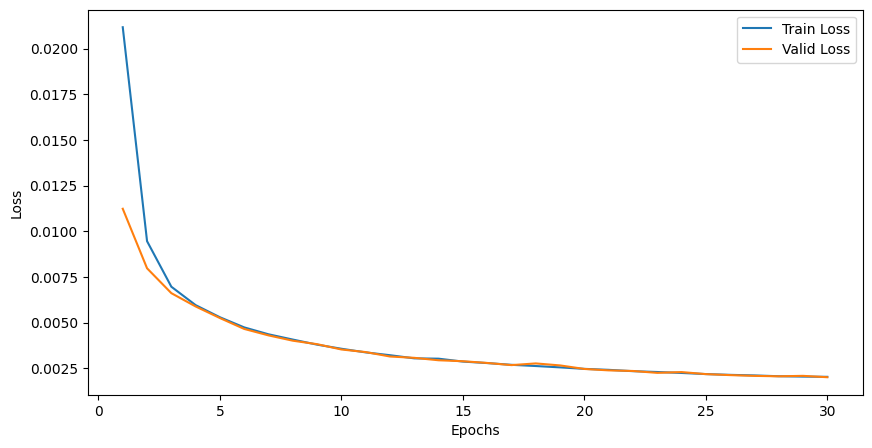

In [109]:
model = Autoencoder()
pretrain(model, pretrain_train_loader, pretrain_valid_loader, pretrain_config)

## Fine-tune with labelled data
<span style="color:orange">(TODO: Loss function / Augmentation)</span>

In [110]:
def cross_entropy_with_label_smoothing(logits, target, smoothing=0.0):
    if smoothing <= 0.0:
        return F.cross_entropy(logits, target)
    smoothing = min(max(smoothing, 0.0), 1.0)
    num_classes = logits.size(1)
    with torch.no_grad():
        true_dist = torch.full_like(logits, smoothing / (num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1.0 - smoothing)
    log_prob = F.log_softmax(logits, dim=1)
    return -(true_dist * log_prob).sum(dim=1).mean()

def loss_fn(x_prime, logits, z, x, target, reconstruction_weight=0.15, smoothing=0.05, latent_reg_weight=1e-4):
    reconstruction_loss = F.mse_loss(x_prime, x)
    classification_loss = cross_entropy_with_label_smoothing(logits, target, smoothing)
    latent_reg = z.norm(dim=1).mean()
    return classification_loss + reconstruction_weight * reconstruction_loss + latent_reg_weight * latent_reg

def finetune(model, train_loader, valid_loader, config, noise_function=add_noise):
    model = model.to(config.device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    use_amp = getattr(config, 'use_amp', False)
    scaler = amp.GradScaler(enabled=use_amp)
    max_grad_norm = getattr(config, 'max_grad_norm', None)

    train_losses = []
    valid_losses = []
    best_valid_acc = 0.0
    best_state_dict = None

    for epoch in range(config.finetune_epochs):
        model.train()
        train_loss, train_acc = 0.0, 0.0
        progress = tqdm(train_loader, desc=f'Finetune {epoch + 1}/{config.finetune_epochs}', leave=False)
        for img, label in progress:
            img = img.to(config.device, non_blocking=True)
            label = label.to(config.device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            noisy_img = noise_function(img, getattr(config, 'noise_factor', 0.0))
            with amp.autocast(enabled=use_amp):
                x_prime, logits, z = model(noisy_img)
                loss = loss_fn(
                    x_prime,
                    logits,
                    z,
                    img,
                    label,
                    reconstruction_weight=config.reconstruction_weight,
                    smoothing=config.label_smoothing,
                    latent_reg_weight=config.latent_reg_weight,
                )

            scaler.scale(loss).backward()
            if max_grad_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            preds = logits.argmax(dim=1)
            batch_acc = (preds == label).float().mean().item()
            train_loss += loss.item()
            train_acc += batch_acc
            progress.set_postfix({'loss': loss.item(), 'acc': batch_acc})

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f'Epoch {epoch + 1}/{config.finetune_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        model.eval()
        valid_loss, valid_acc = 0.0, 0.0
        with torch.no_grad():
            for img, label in valid_loader:
                img = img.to(config.device, non_blocking=True)
                label = label.to(config.device, non_blocking=True)
                with amp.autocast(enabled=use_amp):
                    x_prime, logits, z = model(img)
                    loss = loss_fn(
                        x_prime,
                        logits,
                        z,
                        img,
                        label,
                        reconstruction_weight=config.reconstruction_weight,
                        smoothing=config.label_smoothing,
                        latent_reg_weight=config.latent_reg_weight,
                    )
                valid_loss += loss.item()
                valid_acc += (logits.argmax(dim=1) == label).float().mean().item()

        valid_loss /= len(valid_loader)
        valid_acc /= len(valid_loader)
        scheduler.step(valid_loss)

        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_state_dict = {k: v.cpu() for k, v in model.state_dict().items()}

        print(f'Epoch {epoch + 1}/{config.finetune_epochs}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}')
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        torch.save(best_state_dict, config.finetune_model_path)
    else:
        torch.save(model.state_dict(), config.finetune_model_path)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, config.finetune_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, config.finetune_epochs + 1), valid_losses, label='Valid Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



In [111]:
finetune_train_tfm = T.Compose([
    T.RandomResizedCrop(64, scale=(0.65, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1)
    ], p=0.7),
    T.RandomGrayscale(p=0.1),
    T.RandomApply([T.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),
    T.ToTensor(),
    T.RandomErasing(p=0.2, scale=(0.02, 0.15), ratio=(0.3, 3.3)),
])
finetune_valid_tfm = T.Compose([
    T.Resize(72),
    T.CenterCrop(64),
    T.ToTensor(),
])

finetune_config = Namespace(
    batch_size = 32,
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = 3e-4,
    weight_decay = 1e-4,
    noise_factor = 0.02,
    finetune_epochs = 35,
    max_grad_norm = 1.0,
    reconstruction_weight = 0.15,
    label_smoothing = 0.05,
    latent_reg_weight = 1e-4,
    use_amp = torch.cuda.is_available(),
    finetune_model_path = 'finetune_model.ckpt'
)



In [112]:
finetune_train_data = load_labelled('/docker_data/ysyang/ml/data/dev/labelled')
finetune_train_data, finetune_valid_data = torch.utils.data.random_split(finetune_train_data, [0.8, 0.2])
finetune_train_dataset = ImageDataset(*map(list, zip(*finetune_train_data)), finetune_train_tfm)
finetune_valid_dataset = ImageDataset(*map(list, zip(*finetune_valid_data)), finetune_valid_tfm)

num_workers = min(4, os.cpu_count() or 1)
pin_memory = torch.cuda.is_available()

finetune_train_loader = DataLoader(
    finetune_train_dataset,
    batch_size=finetune_config.batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
finetune_valid_loader = DataLoader(
    finetune_valid_dataset,
    batch_size=finetune_config.batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)



/tmp/ipykernel_746202/2934286906.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler(enabled=use_amp)
Finetune 1/35:   0%|          | 0/94 [00:00<?, ?it/s]/tmp/ipykernel_746202/2934286906.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=use_amp):
                                                                                     

Epoch 1/35, Train Loss: 1.9360, Train Acc: 0.3129


/tmp/ipykernel_746202/2934286906.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=use_amp):


Epoch 1/35, Valid Loss: 1.7375, Valid Acc: 0.3971


Epoch 2/35, Train Loss: 1.7125, Train Acc: 0.4014


Epoch 2/35, Valid Loss: 1.5614, Valid Acc: 0.4596


Epoch 3/35, Train Loss: 1.6607, Train Acc: 0.4243


Epoch 3/35, Valid Loss: 1.5231, Valid Acc: 0.4993


Epoch 4/35, Train Loss: 1.6206, Train Acc: 0.4461


Epoch 4/35, Valid Loss: 1.4520, Valid Acc: 0.4766


Epoch 5/35, Train Loss: 1.5732, Train Acc: 0.4579


Epoch 5/35, Valid Loss: 1.4510, Valid Acc: 0.5134


Epoch 6/35, Train Loss: 1.5057, Train Acc: 0.5000


Epoch 6/35, Valid Loss: 1.4052, Valid Acc: 0.5472


Epoch 7/35, Train Loss: 1.4736, Train Acc: 0.5126
Epoch 7/35, Valid Loss: 1.4010, Valid Acc: 0.5580


Epoch 8/35, Train Loss: 1.4203, Train Acc: 0.5373


Epoch 8/35, Valid Loss: 1.3689, Valid Acc: 0.5685


Epoch 9/35, Train Loss: 1.3936, Train Acc: 0.5469


Epoch 9/35, Valid Loss: 1.3458, Valid Acc: 0.5521


Epoch 10/35, Train Loss: 1.3386, Train Acc: 0.5705


Epoch 10/35, Valid Loss: 1.3560, Valid Acc: 0.5355


Epoch 11/35, Train Loss: 1.3078, Train Acc: 0.5867


Epoch 11/35, Valid Loss: 1.3454, Valid Acc: 0.5619


Epoch 12/35, Train Loss: 1.2950, Train Acc: 0.5966


Epoch 12/35, Valid Loss: 1.2862, Valid Acc: 0.5971


Epoch 13/35, Train Loss: 1.2724, Train Acc: 0.6021


Epoch 13/35, Valid Loss: 1.2901, Valid Acc: 0.5945


Epoch 14/35, Train Loss: 1.2385, Train Acc: 0.6227


Epoch 14/35, Valid Loss: 1.2843, Valid Acc: 0.5911


Epoch 15/35, Train Loss: 1.2289, Train Acc: 0.6230


Epoch 15/35, Valid Loss: 1.2834, Valid Acc: 0.6222


Epoch 16/35, Train Loss: 1.1871, Train Acc: 0.6420


Epoch 16/35, Valid Loss: 1.2265, Valid Acc: 0.6397


Epoch 17/35, Train Loss: 1.1563, Train Acc: 0.6568
Epoch 17/35, Valid Loss: 1.2297, Valid Acc: 0.6228


Epoch 18/35, Train Loss: 1.1569, Train Acc: 0.6601


Epoch 18/35, Valid Loss: 1.2874, Valid Acc: 0.6231


Epoch 19/35, Train Loss: 1.1386, Train Acc: 0.6623


Epoch 19/35, Valid Loss: 1.2205, Valid Acc: 0.6391


Epoch 20/35, Train Loss: 1.0953, Train Acc: 0.6854


Epoch 20/35, Valid Loss: 1.2115, Valid Acc: 0.6326


Epoch 21/35, Train Loss: 1.1029, Train Acc: 0.6885


Epoch 21/35, Valid Loss: 1.2250, Valid Acc: 0.6496


Epoch 22/35, Train Loss: 1.0544, Train Acc: 0.7039


Epoch 22/35, Valid Loss: 1.2318, Valid Acc: 0.6192


Epoch 23/35, Train Loss: 1.0431, Train Acc: 0.7111


Epoch 23/35, Valid Loss: 1.2254, Valid Acc: 0.6529


Epoch 24/35, Train Loss: 1.0393, Train Acc: 0.7098


Epoch 24/35, Valid Loss: 1.2053, Valid Acc: 0.6522


Epoch 25/35, Train Loss: 0.9811, Train Acc: 0.7345
Epoch 25/35, Valid Loss: 1.2464, Valid Acc: 0.6581


Epoch 26/35, Train Loss: 1.0077, Train Acc: 0.7275
Epoch 26/35, Valid Loss: 1.1730, Valid Acc: 0.6717


Epoch 27/35, Train Loss: 0.9576, Train Acc: 0.7373
Epoch 27/35, Valid Loss: 1.1626, Valid Acc: 0.6678


Epoch 28/35, Train Loss: 0.9630, Train Acc: 0.7442


Epoch 28/35, Valid Loss: 1.1922, Valid Acc: 0.6587


Epoch 29/35, Train Loss: 0.9327, Train Acc: 0.7590


Epoch 29/35, Valid Loss: 1.2413, Valid Acc: 0.6561


Epoch 30/35, Train Loss: 0.9458, Train Acc: 0.7537


Epoch 30/35, Valid Loss: 1.1816, Valid Acc: 0.6674


Epoch 31/35, Train Loss: 0.9067, Train Acc: 0.7661


Epoch 31/35, Valid Loss: 1.2263, Valid Acc: 0.6501


Epoch 32/35, Train Loss: 0.9031, Train Acc: 0.7728
Epoch 32/35, Valid Loss: 1.2128, Valid Acc: 0.6512


Epoch 33/35, Train Loss: 0.8739, Train Acc: 0.7814


Epoch 33/35, Valid Loss: 1.2607, Valid Acc: 0.6629


Epoch 34/35, Train Loss: 0.8053, Train Acc: 0.8184


Epoch 34/35, Valid Loss: 1.1870, Valid Acc: 0.6860


Epoch 35/35, Train Loss: 0.7895, Train Acc: 0.8236


Epoch 35/35, Valid Loss: 1.2003, Valid Acc: 0.6773


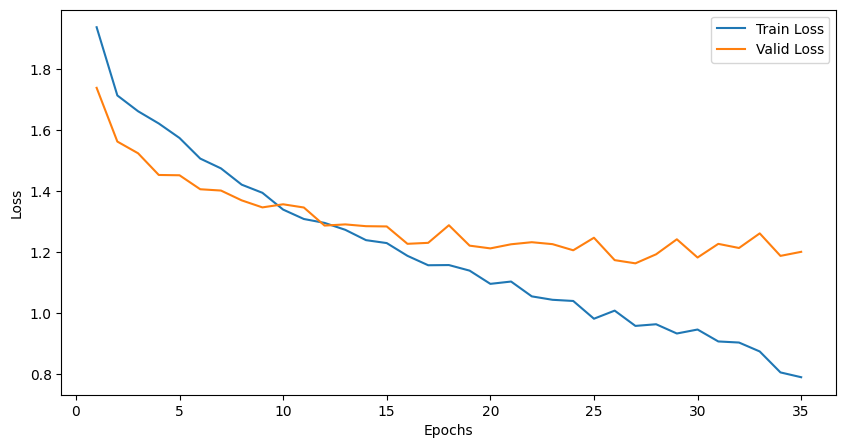

In [113]:
model = Autoencoder()
model.load_state_dict(torch.load(pretrain_config.pretrain_model_path))
finetune(model, finetune_train_loader, finetune_valid_loader, finetune_config)

## Testing

In [86]:
test_dataset = ImageDataset(sorted(load_unlabelled('/docker_data/ysyang/ml/data/test'), key=lambda x: int(x.filename.split('/')[-1].split('.')[0])))
test_loader = DataLoader(test_dataset, batch_size=finetune_config.batch_size, shuffle=False)

model = Autoencoder()
model.load_state_dict(torch.load('finetune_model.ckpt'))
model = model.to(finetune_config.device).eval()

# Generate predictions
predictions = []
with torch.no_grad():
    for img in test_loader:
        img = img.to(finetune_config.device)
        _, y, _ = model(img)
        predictions.append(y.argmax(dim=1).cpu().numpy())
predictions = np.concatenate(predictions)

# Save predictions
with open('predict.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['id', 'label'])
    for id, r in enumerate(predictions):
        writer.writerow([id, r])

## Report

### Clustering
<span style="color:orange">(TODO: Implement the Equilibrium K-means algorithm)</span>
ref: https://arxiv.org/pdf/2402.14490

Distance between a data point $x_n$ and centroid $c_k$
$$d_{ik} = \frac{1}{2} \| x_i - c_k \|^2$$

Equation 38: Weight calculation
$$w_{kn}^{(\tau)} = \frac{e^{-\alpha d_{kn}^{(\tau)}}}{\sum_{i=1}^K e^{-\alpha d_{in}^{(\tau)}}}
\left[ 1 - \alpha \left( d_{kn}^{(\tau)} -
\frac{\sum_{i=1}^K d_{in}^{(\tau)} e^{-\alpha d_{in}^{(\tau)}}}{\sum_{i=1}^K e^{-\alpha d_{in}^{(\tau)}}}
\right) \right]$$

Equation 39: Centroid update
$$c_k^{(\tau+1)} = \frac{\sum_{n=1}^N w_{kn}^{(\tau)} x_n}{\sum_{n=1}^N w_{kn}^{(\tau)}}$$

<img src="https://dt5vp8kor0orz.cloudfront.net/5fedcaeba7180898deb71d026db359b0a56af6b3/9-Figure4-1.png" width="1000"/>

In [ ]:
import numpy as np

def equilibrium_k_means(X, k, alpha, n_iter):
    centroids = initialize_centroids(X, k) # Initialize centroids
    for _ in range(n_iter):
        weights = Eq38_compute_weights(X, centroids, alpha)  # Compute weights
        centroids = Eq39_update_centroids(X, weights)    # Update centroids
    return centroids

def initialize_centroids(X, k):
    # Initialize centroids as random samples
    return X[np.random.choice(X.shape[0], k, replace=False)]

def Eq38_compute_weights(X, centroids, alpha):
    #==== TODO: Compute the weights for each data point (refer to Eq. 38) ====#



    #=========================================================================#
    return weights

def Eq39_update_centroids(X, weights):
    #==== TODO: Update the centroids (refer to Eq. 39) ====#


    #======================================================#
    return centroids

def select_clusters(weights):
    return np.argmax(weights, axis=1)

def plot_clusters(X, centroids, clustering, title='Equilibrium K-Means Clustering'):
    plt.scatter(X[:,0], X[:,1], c=clustering, cmap='viridis')
    plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='x')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

# Example usage
'''
X1 = np.random.rand(100, 2) + np.array([[0.2,0.2]])
X2 = np.random.rand(20, 2) + np.array([[0.2,1.6]])
X3 = np.random.rand(80, 2) + np.array([[2.0,0.5]])
X = np.concatenate([X1, X2, X3])

k = 3  # Number of clusters
alpha = 10  # Smoothing parameter
n_iter = 50  # Number of iterations

centroids = equilibrium_k_means(X, k, alpha, n_iter)
print("Final centroids:\n", centroids)
print("Real centroids:\n", np.array([np.mean(X1, axis=0), np.mean(X2, axis=0), np.mean(X3, axis=0)]))

# Visualize the clustering - show the data points and the centroids
clustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))
plot_clusters(X, centroids, clustering)'''

### t-SNE
<span style="color:orange">(TODO: Implement t-SNE)</span>

In [ ]:
import sklearn
from sklearn import manifold

def prune_dimension(X):
    # args: X (n_samples, dim)
    # ouput: Y (n_samples, 2)
    # TODO: implement t-SNE

    return X[:, :2]

### Demo with validation set
This section demonstrate the functionality of t-SNE and clustering with the finetuning validation set.
 - Use clustered label
 - Use ground truth label

In [ ]:
import numpy as np

# Generate X, label
X, label = [], []
with torch.no_grad():
    for img, lab in finetune_valid_dataset:
        _, probs, latent_embedding = model(img.unsqueeze(0).to(finetune_config.device))
        X.append(latent_embedding.cpu().numpy())
        label.append(lab)
X, label = np.concatenate(X), np.array(label)

# consider three classes
cls1, cls2, cls3 = 2, 5, 8
cls_idx = np.where((label==cls1) | (label==cls2) | (label==cls3))
X = X[cls_idx]
label = label[cls_idx]

# Perform equilibrium k-means clustering
k = 3
alpha = 0.01
n_iter = 50
centroids = equilibrium_k_means(X, k, alpha, n_iter)
clustering = select_clusters(Eq38_compute_weights(X, centroids, alpha))

# t-SNE
Y = prune_dimension(np.concatenate([X, centroids]))
Y, centroids = Y[:-3], Y[-3:]

# plot
plot_clusters(Y, centroids, clustering)
plot_clusters(Y, centroids, label, 'Labelled')

### Anomaly detection
This section demonstrate the usage of autoencoders for anomaly detection.

We use the autoencoder to reconstruct an image of an unseen class.

In [ ]:
# train on class 1 (cars)
class1_dataset = ImageDataset(load_unlabelled('./data/dev/labelled/2/'))
class1_loader = DataLoader(class1_dataset, batch_size=8, shuffle=True)
model = Autoencoder()
pretrain(model, class1_loader, None, Namespace(
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    lr = pretrain_config.lr,
    weight_decay = 0,
    noise_factor = 0,
    pretrain_epochs = 50
))

In [ ]:
# Use the anomaly dataset and the pre-trained model to generate latent embeddings
anomaly_dataset = ImageDataset(load_unlabelled('data/anomoly'), tfm=T.Compose([
    T.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by adding channels
    T.ToTensor()
]))
anomaly_loader = DataLoader(anomaly_dataset, batch_size=pretrain_config.batch_size, shuffle=False)

# compare losses
anomaly_loss = []
with torch.no_grad():
    for image in anomaly_loader:
        image = image.to(pretrain_config.device)
        recon, _, _ = model(image)
        loss = nn.MSELoss()(recon, image)
        anomaly_loss.append(loss.item())
anomaly_loss = sum(anomaly_loss) / len(anomaly_loss)
print('Anomaly loss:', anomaly_loss)

class1_loss = []
with torch.no_grad():
    for image in class1_loader:
        image = image.to(pretrain_config.device)
        recon, _, _ = model(image)
        loss = nn.MSELoss()(recon, image)
        class1_loss.append(loss.item())
class1_loss = sum(class1_loss) / len(class1_loss)
print('Normal loss :', class1_loss)

# Show
# 1. a pair of reconstructed image and original image for the anomaly class
# 2. a pair of reconstructed image and original image for the normal class
idx1, idx2 = 42, 10
image1, image2 = anomaly_dataset[idx1], class1_dataset[idx2]
model.eval()
with torch.no_grad():
    recon1 = model(image1.unsqueeze(0).to(pretrain_config.device))[0].cpu().numpy()
    recon2 = model(image2.unsqueeze(0).to(pretrain_config.device))[0].cpu().numpy()

# plot the 4 images
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].imshow(image1.numpy().transpose((1, 2, 0)))
axs[0, 0].set_title('Anomaly Image')
axs[0, 1].imshow(recon1.squeeze().transpose((1, 2, 0)))
axs[0, 1].set_title('Reconstructed Anomaly Image')
axs[1, 0].imshow(image2.numpy().transpose((1, 2, 0)))
axs[1, 0].set_title('Normal Image')
axs[1, 1].imshow(recon2.squeeze().transpose((1, 2, 0)))
axs[1, 1].set_title('Reconstructed Normal Image')
plt.show()